In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from collections import Counter
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score)
from openai import AzureOpenAI
from tqdm import tqdm

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Load the dataset
file_path = '/content/drive/MyDrive/NLP Project/data/combined_dataset.csv'
df = pd.read_csv(file_path)

# Show the first few rows
df.head()

,text,label,dataset
0,Intravenous azithromycin-induced ototoxicity.,1,ade_classification_dataset
1,"Immobilization, while Paget's bone disease was...",1,ade_classification_dataset
2,Unaccountable severe hypercalcemia in a patien...,1,ade_classification_dataset
3,METHODS: We report two cases of pseudoporphyri...,1,ade_classification_dataset
4,METHODS: We report two cases of pseudoporphyri...,1,ade_classification_dataset


In [6]:
# Print dataset shape
print(f"Shape of dataset: {df.shape}\n")

# Create summary table
summary = pd.DataFrame({
    'Column': df.columns,
    'Missing Values': df.isnull().sum().values,
    'Data Type': df.dtypes.values
})

# Display table
summary

Shape of dataset: (29525, 3)



,Column,Missing Values,Data Type
0,text,1,object
1,label,0,int64
2,dataset,0,object


In [7]:
df["dataset"].value_counts()

,count
dataset,
ade_classification_dataset,23516
PsyTAR_dataset,6009


In [8]:
# How many 0 and 1 labels does ade_classification_dataset have
df[df["dataset"] == "ade_classification_dataset"]["label"].value_counts()

,count
label,
0,16695
1,6821


In [9]:
# How many 0 and 1 labels does PsyTAR_dataset have
df[df["dataset"] == "PsyTAR_dataset"]["label"].value_counts()

,count
label,
0,3841
1,2168


### Checking for missing:

In [10]:
df[df['text'].isna()]

,text,label,dataset
24358,NaN,0,PsyTAR_dataset


In [11]:
# Dropping the missing column
df = df.dropna(subset=['text']).reset_index(drop=True)

We dropped the row with the missing text value since it didn't give us any information.

In [12]:
# Display how text column looks
df['text'].value_counts()

,count
text,
"A 27-year-old man who had a history of bronchial asthma, eosinophilic enteritis, and eosinophilic pneumonia presented with fever, skin eruptions, cervical lymphadenopathy, hepatosplenomegaly, atypical lymphocytosis, and eosinophilia two weeks after receiving trimethoprim (TMP)-sulfamethoxazole (SMX) treatment.",24
"CASE SUMMARY: A 65-year-old patient chronically treated with the selective serotonin reuptake inhibitor (SSRI) citalopram developed confusion, agitation, tachycardia, tremors, myoclonic jerks and unsteady gait, consistent with serotonin syndrome, following initiation of fentanyl, and all symptoms and signs resolved following discontinuation of fentanyl.",21
A case report.,21
"CONCLUSION: The new quinolone derivatives (levofloxacin, sparfloxacin, grepafloxacin, trovafloxacin, gatifloxacin and moxifloxacin), also called gyrase inhibitors, are known for their potential to cause central nervous system-related adverse effects, including headache, dizziness and insomnia.",18
"Rapamycin/sirolimus (SR), trade named Rapammune (Wyeth-Ayerst, Sydney, Australia), is a potent immunosuppressive drug associated with myelosuppression, hypertension, hyperlipidemia, and infection.",16
...,...
"We present a report of B. henselae infection transmitted by the same kitten to 4 different individuals, each with different clinical characteristics, treatment, and evolution.",1
Successful treatment was achieved with partial resection of the posterior mitral valve leaflet and antibiotic therapy.,1
"The pathogenesis of the porphyria is not clear; however, cyclophosphamide is a substrate for cytochrome P450, and may produce metabolites that destroy this protein.",1


We can already see duplicates here.

In [13]:
# Check number of duplicate rows
num_duplicates = df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 2639


In [14]:
# Drop duplicate rows and reset index
df = df.drop_duplicates().reset_index(drop=True)

# Check shape after removal
print(f"New shape after dropping duplicates: {df.shape}")

New shape after dropping duplicates: (26885, 3)


In [15]:
print("Unique labels:", df['label'].unique())
print("Number of unique texts:", df['text'].nunique())

Unique labels: [1 0]
Number of unique texts: 26885


In [16]:
df["dataset"].value_counts()

,count
dataset,
ade_classification_dataset,20896
PsyTAR_dataset,5989


The dataset includes two sources: ade_classification_dataset with 20,896 sentences and PsyTAR_dataset with 5,989 sentences. Most of the data comes from the ADE dataset.

In [17]:
# # Filter rows where text contains "interventional case report"
# interventional_sentences = df[df['text'].str.contains('interventional case report', case=False, na=False)]

# # Get unique sentences as a set
# unique_interventional_sentences = set(interventional_sentences['text'])

# # Display the sentences
# for sentence in unique_interventional_sentences:
#     print(sentence)

### Label Distribution:

In [18]:
# Get counts as a dictionary
counts = df['label'].value_counts().to_dict()

# Create DataFrame from counts
label_counts_df = pd.DataFrame(list(counts.items()), columns=['label', 'count'])

# Calculate percentages
label_counts_df['percentage'] = round((label_counts_df['count'] / label_counts_df['count'].sum()) * 100, 2)

# Display DataFrame
print("\nLabel Distribution:\n")
label_counts_df


Label Distribution:



,label,count,percentage
0,0,20450,76.06
1,1,6435,23.94


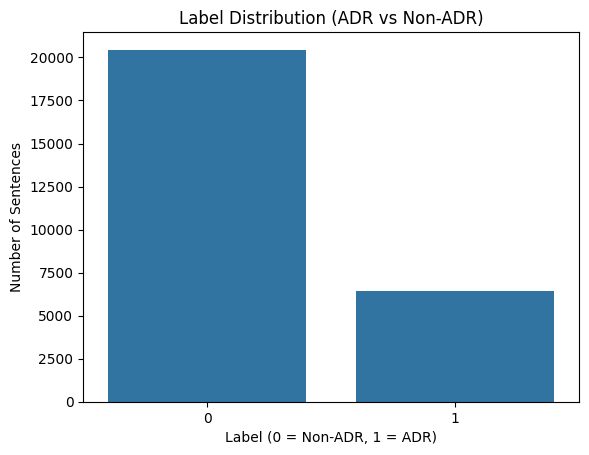

In [19]:
# Plot label distribution
sns.countplot(x='label', data=df)
plt.title('Label Distribution (ADR vs Non-ADR)')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Sentences')
plt.show()

The dataset shows a clear class imbalance, with ~76% non-ADR sentences and ~24% ADR sentences. This imbalance should be considered during model training and evaluation.

In [20]:
# Calculate sentence lengths
sentence_lengths = df['text'].apply(lambda x: len(str(x).split()))

# Get sentence length stats as DataFrame
sentence_stats = sentence_lengths.describe().round(2).to_frame().T

# Display
sentence_stats

,count,mean,std,min,25%,50%,75%,max
text,26885.0,17.21,8.95,1.0,11.0,16.0,22.0,156.0


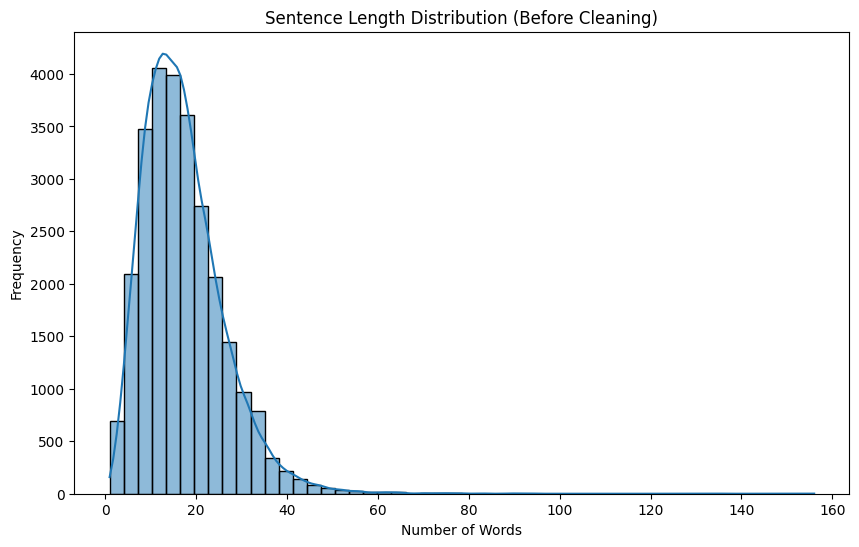

In [21]:
# Display in plot
plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths, bins=50, kde=True)
plt.title('Sentence Length Distribution (Before Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

We analyzed the distribution of sentence lengths in the ADE dataset (measured in word count per sentence). The dataset contains 26,885 sentences (after duplicates + missing removal), with an average length of approximately 17.21 words (SD = 8.95). The shortest sentence contains 1 word, while the longest reaches 156 words. The 25th percentile is at 11 words, the median at 16 words, and the 75th percentile at 22 words. These results show that while most sentences are relatively short, the dataset includes some very long and complex sentences, which could impact both embedding-based models and LLM prompting (due to token limits and truncation risk).

### Checking Which Label Has Longer Sentences:

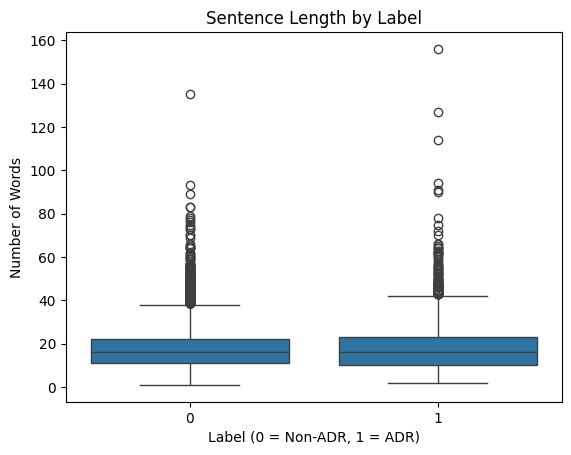

In [22]:
sns.boxplot(x='label', y=sentence_lengths, data=df)
plt.title('Sentence Length by Label')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Words')
plt.show()

We visualized the sentence length distribution by label (ADR vs Non-ADR) before text cleaning. The updated plot shows that sentences labeled as ADR (1) tend to be slightly longer than Non-ADR (0) on average, with a slightly higher median and more extreme outliers. This suggests that ADR-related sentences may contain more descriptive or detailed language.

In [23]:
# Flatten all raw text into one big string - split into raw tokens
all_raw_words = [word.lower()
                 for sentence in df['text']
                 for word in str(sentence).split()]

# Count word frequencies
raw_word_freq = Counter(all_raw_words)

# Get top 20 most common words
most_common_raw = raw_word_freq.most_common(20)

print("\nTop 20 most common words:\n")
for word, count in most_common_raw:
    print(f"{word}, ({count})")

# Get top 20 least common words
least_common_raw = raw_word_freq.most_common()[:-21:-1]

print("\nTop 20 least common words:\n")
for word, count in least_common_raw:
    print(f"{word}, ({count})")


Top 20 most common words:

of, (18561)
the, (18118)
and, (13629)
a, (11101)
in, (9674)
with, (8842)
to, (8615)
was, (4838)
for, (4285)
i, (4239)
is, (4036)
after, (3016)
this, (2880)
patients, (2533)
that, (2449)
patient, (2294)
be, (2206)
on, (2154)
an, (2150)
case, (2075)

Top 20 least common words:

withdrawals,, (1)
scarey,, (1)
resort., (1)
jags., (1)
symptons, (1)
long/low, (1)
gets,, (1)
labido., (1)
doubt., (1)
medicine's, (1)
loss-40, (1)
approx,, (1)
disapeared., (1)
unfortunately., (1)
effect), (1)
(good, (1)
topamax,, (1)
coffee., (1)
a,m,, (1)
1:30, (1)


The most common words in the dataset are generic stopwords such as “of”, “the”, and “and”, which frequently appear in natural language but carry little semantic meaning. In contrast, the least common words are a mix of rare medical terms (e.g., “symptons”, “topamax”), typographical errors (e.g., “scarey,,”, “disapeared.”), and noisy or malformed tokens (e.g., “a,m,” and “1:30”). These findings highlight the importance of preprocessing steps like stopword removal, spelling correction, and token cleanup to improve model input quality.

### Text Cleaning:

In [24]:
# Minimal cleaning function - lowercase + remove punctuation
def minimal_clean(text):
    text = str(text).lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# Apply cleaning
df['text'] = df['text'].apply(minimal_clean)

In [25]:
df['text'].value_counts()

,count
text,
zoloft weight gain,3
lexapro changed my life,2
lexapro it was horrible,2
lexapro none,2
cymbalta non,2
...,...
this methodology provides the decision analyst with a procedure to evaluate the outcome of specification uncertainty in many decision problems without resorting to monte carlo analysis,1
administration of the drug for 8 days did not effectively shorten the recovery period compared with the average reported in the literature without the drug and may have triggered additional iatrogenic complications,1
the patients ewing sarcoma remained refractory to treatment despite continuous intensified chemotherapy and was complicated by a therapyrelated acute myeloid leukemia with 11q23 abnormality,1


In [26]:
# Find duplicated texts (keep both rows)
duplicates_df = df[df['text'].duplicated(keep=False)]

# Show them
duplicates_df

,text,label,dataset
8098,design interventional case report,0,ade_classification_dataset
13664,design interventional case report,0,ade_classification_dataset
21085,lexapro beware,0,PsyTAR_dataset
21213,lexapro,0,PsyTAR_dataset
21426,lexapro beware,0,PsyTAR_dataset
21458,lexapro changed my life,0,PsyTAR_dataset
21560,lexapro it was horrible,0,PsyTAR_dataset
21806,lexapro,0,PsyTAR_dataset
21858,lexapro loss of appetite,1,PsyTAR_dataset
21998,lexapro none,0,PsyTAR_dataset


In [27]:
df = df.drop_duplicates(subset='text', keep='first').reset_index(drop=True)

After cleaning the data, several duplicate texts appeared with the same labels. To avoid repetition and improve model performance, we removed the duplicates and kept only the first version of each.

In [28]:
df.shape

(26867, 3)

### Word Statistics:

In [29]:
# Flatten all tokens into one big list
all_words = [word for sentence in df['text'] for word in sentence.split()]

# Count total words
total_word_count = len(all_words)
print(f"Total number of words: {total_word_count}")

# Count unique words
unique_word_count = len(set(all_words))
print(f"\nNumber of unique words: {unique_word_count}")

# Get word frequencies
word_freq = Counter(all_words)

# Get top 20 most common words
most_common_words = word_freq.most_common(20)

# Print top 20 most common words as grocery list
print("\nTop 20 most common words:\n")
for word, count in most_common_words:
    print(f"{word},({count})")

# Get top 20 least common words (appear only once or few times)
least_common_words = word_freq.most_common()[:-21:-1]

# Print top 20 least common words as grocery list
print("\nTop 20 least common words:\n")
for word, count in least_common_words:
    print(f"{word},({count})")

Total number of words: 462108

Number of unique words: 23134

Top 20 most common words:

of,(18581)
the,(18138)
and,(13696)
a,(11133)
in,(9690)
with,(8869)
to,(8640)
was,(4851)
for,(4294)
i,(4266)
is,(4056)
patients,(3227)
after,(3019)
this,(2935)
patient,(2547)
that,(2520)
treatment,(2519)
case,(2229)
be,(2218)
on,(2190)

Top 20 least common words:

longlow,(1)
labido,(1)
loss40,(1)
disapeared,(1)
topamax,(1)
disaster,(1)
poverty,(1)
187month,(1)
overstimulationinsomnia,(1)
boards,(1)
spirals,(1)
pulsating,(1)
hassle,(1)
als,(1)
subtly,(1)
youth,(1)
prozach,(1)
majorly,(1)
goofy,(1)
heap,(1)


### Words per Sentence:

In [30]:
# Calculate sentence lengths
sentence_lengths_cleaned = df['text'].apply(lambda x: len(x.split()))

# Get word statistics per sentence
sentence_stats_cleaned_summary = sentence_lengths_cleaned.describe().round(2).to_frame().T

# Display
print("Word Statistics per Sentence:\n")
sentence_stats_cleaned_summary

Word Statistics per Sentence:



,count,mean,std,min,25%,50%,75%,max
text,26867.0,17.2,8.91,1.0,11.0,16.0,22.0,155.0


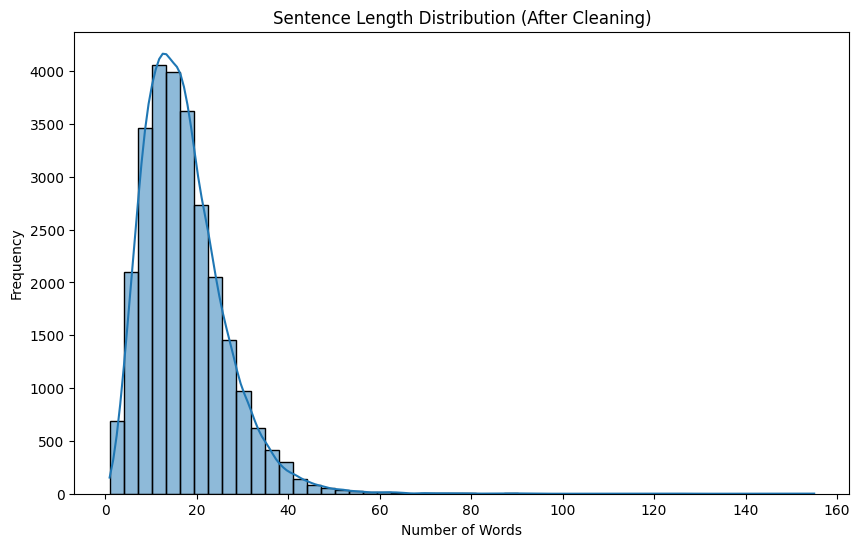

In [31]:
# Display in plot
plt.figure(figsize=(10,6))
sns.histplot(sentence_lengths_cleaned, bins=50, kde=True)
plt.title('Sentence Length Distribution (After Cleaning)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

There is a sentence with 155 words and with 1. Thus, we will check the longest and shortest sentences and their labels.

In [32]:
# Calculate sentence lengths as a variable
sentence_lengths = df['text'].apply(lambda x: len(x.split()))

# Find the shortest sentence
shortest_idx = sentence_lengths.idxmin()
shortest_sentence = df.loc[shortest_idx, 'text']
shortest_length = sentence_lengths[shortest_idx]
shortest_label = df.loc[shortest_idx, 'label']

# Find the longest sentence
longest_idx = sentence_lengths.idxmax()
longest_sentence = df.loc[longest_idx, 'text']
longest_length = sentence_lengths[longest_idx]
longest_label = df.loc[longest_idx, 'label']

# Display results
print(f"Shortest sentence:\n\n({shortest_length} words, label {shortest_label}):\n{shortest_sentence}\n")
print(f"Longest sentence:\n\n({longest_length} words, label {longest_label}):\n{longest_sentence}\n")

Shortest sentence:

(1 words, label 0):
abemayor

Longest sentence:

(155 words, label 1):
zoloft increased migraine and headaches frequency went from very rarely to frequently vomitting nausea initially constipated then just diarrhea disturbing twitching while trying to fall asleep not the usual twitching very dry mouth loss of libido  got better when i decreased from 150mg to 100 mg after 3 months also have occasional yawnitis as i call it which was worse in the beginning also had terrible motion sickness i have never had before from flying alot of dizziness if i forget my dose after just an hour since i decreased to 100mg a month ago irritability fall asleep at work sometimes lasting all day somewhat better after taking the medicine at noontime waking up in the middle of the night is completely resolved since taking the meds at noontime rather than before bed definitely i am not losing weight had panic attacks and that weird tingly feeling for first 2 weeks but these went away



The longest sentence, labeled as ADR (1), contains a detailed and unstructured list of side effects experienced from Zoloft, highlighting the complexity and richness of real-world adverse drug reports. Its length and content suggest the importance of handling long, noisy inputs when working with patient-generated text in NLP models.

### Checking Which Label Has Longer Sentences:

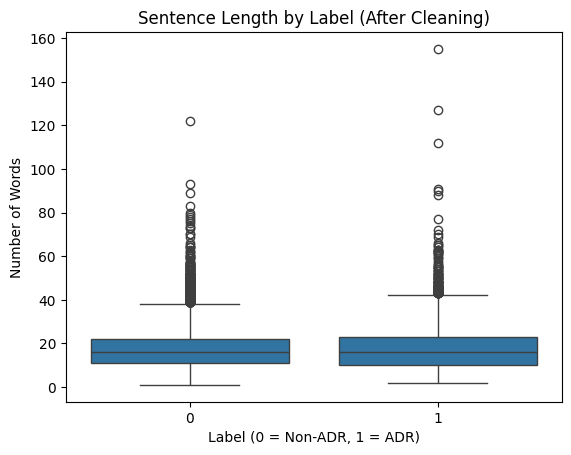

In [33]:
# Plot sentence length distribution by label
sns.boxplot(x=df['label'], y=sentence_lengths_cleaned)
plt.title('Sentence Length by Label (After Cleaning)')
plt.xlabel('Label (0 = Non-ADR, 1 = ADR)')
plt.ylabel('Number of Words')
plt.show()

In [34]:
# Get counts as a dictionary
counts = df['label'].value_counts().to_dict()

# Create DataFrame from counts
label_counts_df = pd.DataFrame(list(counts.items()), columns=['label', 'count'])

# Calculate percentages
label_counts_df['percentage'] = round((label_counts_df['count'] / label_counts_df['count'].sum()) * 100, 2)

# Display DataFrame
print("\nLabel Distribution:\n")
label_counts_df


Label Distribution:



,label,count,percentage
0,0,20436,76.06
1,1,6431,23.94


### Letters per Word:

In [35]:
# Calculate total words and total letters
total_words = len(all_words)
total_letters = sum(len(word) for word in all_words)

# Create summary DataFrame
summary_df = pd.DataFrame({
    'Metric': ['Total Words', 'Total Letters'],
    'Value': [total_words, total_letters]
})

# Display summary DataFrame
summary_df

,Metric,Value
0,Total Words,462108
1,Total Letters,2644876


In [36]:
# Calculate letter statistics per word (only count shows word amount)

word_lengths = [len(word) for word in all_words]

# Convert to a pandas Series for easy summary stats
word_lengths_series = pd.Series(word_lengths, name='Amount')

# Print summary statistics
print("Letter Statistics per Word:\n")
word_lengths_series.describe().round(2)

Letter Statistics per Word:



,Amount
count,462108.00
mean,5.72
std,3.47
min,1.00
25%,3.00
50%,5.00
75%,8.00
max,42.00


In [37]:
# Count number of words per character length
length_counts = word_lengths_series.value_counts().sort_index()

# Display as a DataFrame
length_counts_df = pd.DataFrame({
    'word_length': length_counts.index,
    'count': length_counts.values
})

length_counts_df

,word_length,count
0,1,19153
1,2,69058
2,3,69302
3,4,57241
4,5,38717
5,6,32116
6,7,37936
7,8,38585
8,9,33252
9,10,22797


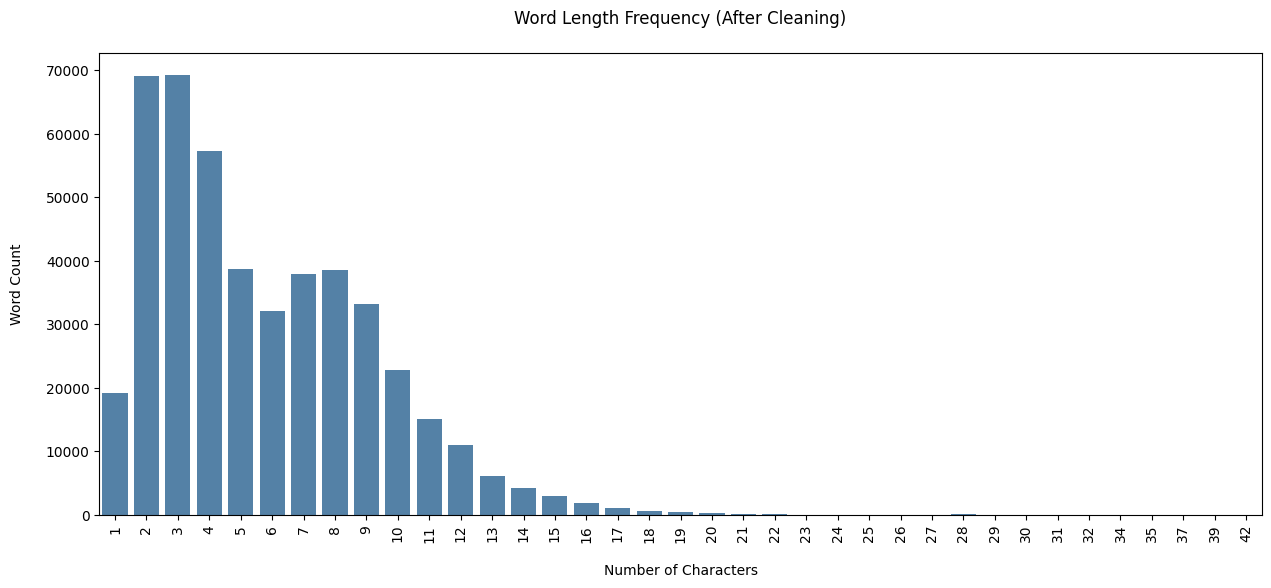

In [38]:
# Plotting the results
plt.figure(figsize=(15, 6))
sns.barplot(x=length_counts.index, y=length_counts.values, color='steelblue')
plt.title('Word Length Frequency (After Cleaning)\n')
plt.xlabel('\nNumber of Characters')
plt.ylabel('Word Count\n')
plt.xticks(rotation=90)
plt.show()

In [39]:
# Find all words with length >= 30
long_words = [word for word in all_words if len(word) >= 30]

# Get unique long words
unique_long_words = set(long_words)

# Display the unique long words
print("Words with 30 and more letters:\n")
for word in unique_long_words:
    print(word)

Words with 30 and more letters:

tricyclicantidepressantinduced
2chlorophenyl4chlorophenyl11dichloroethane
clinicalelectroencephalographic
microbiologicalcharacteristics
reuptakeinhibitorsmetoclopramide
polyendocrinopathycandidiasisectodermal
methicillinresistantstaphylococcus
s23aminopropylaminoethylphosphorothioic
34methylenedioxymetamphetamine
tremorsdizzinessheadachesangerfits
n4behenoyl1betadarabinofuranosyl
histologicalimmunohistochemical
antineoplasticimmunosuppressive
trimethoprimsulfamethoxazoleinduced
hypothalamicpituitaryadrenocortical
multipleantimicrobialresistant
34methylenedioxymethamphetamine
prothipendylhydrochlorideinduced
1betadarabinofuranosylcytosine
chromatographynitrogenphosphorus
glipizidetrimethoprimsulfamethoxazole
8hydroacydesmethylclomipramine
derealizationdepersonalization


We identified several unusually long words (≥30 characters), which are often complex medical terms, chemical names, or drug identifiers.

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26867 entries, 0 to 26866
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     26867 non-null  object
 1   label    26867 non-null  int64 
 2   dataset  26867 non-null  object
dtypes: int64(1), object(2)
memory usage: 629.8+ KB


### Baseline Model - Bag of Words + Naive Bayes:

Since our dataset is imbalanced, with approximately 76% Non-ADR and 24% ADR examples, we will apply downsampling to the Non-ADR class to match the number of ADR examples. This ensures a balanced dataset, helping to prevent the model from being biased toward the majority class. By doing so, we aim to improve the model’s ability to correctly identify ADR cases and achieve more reliable performance metrics during evaluation.

In [41]:
# Separate majority and minority classes
df_majority = df[df['label'] == 0]
df_minority = df[df['label'] == 1]

# Downsample majority class
df_majority_downsampled = df_majority.sample(n=len(df_minority), random_state=0)

# Combine minority class with downsampled majority class
df = pd.concat([df_majority_downsampled, df_minority])

# Shuffle the balanced dataset
df = df.sample(frac=1, random_state=0).reset_index(drop=True)

# Check the new label distribution
label_counts = df['label'].value_counts().reset_index()
label_counts.columns = ['Label', 'Count']
label_counts

,Label,Count
0,0,6431
1,1,6431


In [42]:
# Split data into train+dev and test first (80% train+dev, 20% test)
X_temp, X_test, y_temp, y_test = train_test_split(
    df['text'], df['label'],
    test_size=0.2, stratify=df['label'], random_state=0
)

# Split train+dev into train and dev (75% train, 25% dev → overall 60% train, 20% dev, 20% test)
X_train, X_dev, y_train, y_dev = train_test_split(
    X_temp, y_temp,
    test_size=0.25, stratify=y_temp, random_state=0
)

# Vectorize with Bag of Words (fit only on training set)
vectorizer = CountVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_dev_vec = vectorizer.transform(X_dev)
X_test_vec = vectorizer.transform(X_test)

# Train Naive Bayes on training set
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

# Predict on train set
y_train_pred = nb_model.predict(X_train_vec)

# Calculate train metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred)
train_recall = recall_score(y_train, y_train_pred)
train_f1 = f1_score(y_train, y_train_pred)

# Predict on dev set
y_dev_pred = nb_model.predict(X_dev_vec)

# Calculate dev metrics
dev_accuracy = accuracy_score(y_dev, y_dev_pred)
dev_precision = precision_score(y_dev, y_dev_pred)
dev_recall = recall_score(y_dev, y_dev_pred)
dev_f1 = f1_score(y_dev, y_dev_pred)

# Predict on test set
y_test_pred = nb_model.predict(X_test_vec)

# Calculate test metrics
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)

# Create DataFrame with results
metric_table = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score'],
    'Train Score': [round(train_accuracy, 2), round(train_precision, 2), round(train_recall, 2), round(train_f1, 2)],
    'Dev Score': [round(dev_accuracy, 2), round(dev_precision, 2), round(dev_recall, 2), round(dev_f1, 2)],
    'Test Score': [round(test_accuracy, 2), round(test_precision, 2), round(test_recall, 2), round(test_f1, 2)]
})

# Display DataFrame
metric_table

,Metric,Train Score,Dev Score,Test Score
0,Accuracy,0.89,0.76,0.76
1,Precision,0.86,0.73,0.73
2,Recall,0.94,0.82,0.81
3,F1 Score,0.90,0.77,0.77


In this baseline experiment, a Multinomial Naive Bayes classifier was trained on text data vectorized using a Bag of Words approach. The data was split into training (60%), development (20%), and test (20%) sets, ensuring balanced label distribution through stratification. The model achieved high performance on the training set (F1 score = 0.90), with a moderate drop on the development and test sets (both F1 = 0.77), indicating slight overfitting but generally good generalization. Since the task involves detecting adverse drug reactions (ADR), recall is a key metric, as false negatives could mean missing harmful effects. The model maintained strong recall scores across all splits — 0.94 (train), 0.82 (dev), and 0.81 (test) — suggesting it effectively identifies most ADR-related texts. However, the lower precision (0.73 on dev/test) indicates some false positives, a tradeoff that may be acceptable in favor of higher recall in this context.

### Baseline Model - gpt-4o-mini Zero-shot:

In [43]:
!pip install openai --quiet

In [44]:
# Set your Azure config
api_version = "2024-12-01-preview"
endpoint = "https://nicol-mb4v0ow8-eastus2.openai.azure.com/"
deployment = "gpt-4o-mini"
api_key = "2EJ4zmkuQsxz5Z6H2J8V6CWrTlqF64E60d0DyY26sZcK28HvSsbBJQQJ99BEACHYHv6XJ3w3AAAAACOGsCa2"

# Initialize client
client = AzureOpenAI(
    api_version=api_version,
    azure_endpoint=endpoint,
    api_key=api_key,
)

In [45]:
# Zero-Shot Classifier
def zero_shot_gpt_classify(text):
    prompt = f"""
You are a medical NLP classifier.

Classify the following sentence as describing an Adverse Drug Reaction (ADR) or not.

Sentence:
"{text}"

Respond with only a single digit:
- Respond 1 if it describes an ADR.
- Respond 0 if it does NOT describe an ADR.
"""
    try:
        response = client.chat.completions.create(
            model=deployment,
            messages=[
                {"role": "system", "content": "You are a helpful assistant."},
                {"role": "user", "content": prompt.strip()}
            ],
            max_tokens=5,
            temperature=0.0,
        )
        output = response.choices[0].message.content.strip()
        return int(output) if output in ['0', '1'] else None
    except Exception as e:
        print(f"Error: {e}")
        return None

In [46]:
# Create a test dataframe from your earlier split
df_test = pd.DataFrame({'text': X_test, 'label': y_test})

df_test['gpt_pred'] = [
    zero_shot_gpt_classify(text) for text in tqdm(df_test['text'], desc="GPT-4o-mini Zero-Shot Classification")
]

# Drop rows where the model failed (returned None)
df_test_clean = df_test.dropna(subset=['gpt_pred'])

# Evaluation
y_true = df_test_clean['label']
y_pred = df_test_clean['gpt_pred']

# 5. Creating a metrics DataFrame
metrics = {
    "Metric": ["Accuracy", "Precision", "Recall", "F1 Score"],
    "GPT-4o-mini Score": [
        round(accuracy_score(y_true, y_pred), 2),
        round(precision_score(y_true, y_pred), 2),
        round(recall_score(y_true, y_pred), 2),
        round(f1_score(y_true, y_pred), 2)
    ]
}

metrics_df = pd.DataFrame(metrics)

# Results
metrics_df

GPT-4o-mini Zero-Shot Classification: 100%|██████████| 2573/2573 [23:23<00:00,  1.83it/s]


,Metric,GPT-4o-mini Score
0,Accuracy,0.83
1,Precision,0.79
2,Recall,0.90
3,F1 Score,0.84


The GPT-4o-mini zero-shot baseline achieved strong results on the test set, with an accuracy of 0.83, recall of 0.90, and F1 score of 0.84. Its high recall suggests it effectively identifies most ADR cases, while the precision of 0.79 indicates a manageable level of false positives. These results highlight its effectiveness as a zero-shot benchmark for ADR classification.